In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=d63ba760e874c06e94b40991933ad57ada101600c5ab33b6b29099e6182b9ffd
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


## **Import modules**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Activation,Flatten,Dropout,LSTM,TimeDistributed
from keras.utils import to_categorical
from keras import backend as k
from sklearn.utils.class_weight import compute_class_weight
import os
import random
import cv2
from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc,logfbank
import librosa

Using TensorFlow backend.


## **Load the wav files**

In [ ]:
datadir='/content/drive/My Drive/wavfiles'
instruments=['Acoustic_guitar','Bass_drum','Cello','Clarinet','Double_bass','Flute','Hi_hat','Saxophone','Snare_drum','Violin_or_fiddle']
files=[]

for i in instruments:
  path=os.path.join(datadir,i)
  ins=i
  for music in os.listdir(path):
    files.append([music,ins])

df=pd.DataFrame(files,columns=['fname','label'])
df.set_index('fname',inplace=True)
print(df.head())

                        label
fname                        
367ad7b1.wav  Acoustic_guitar
0eeaebcb.wav  Acoustic_guitar
32dee61b.wav  Acoustic_guitar
236cbab1.wav  Acoustic_guitar
16c9a838.wav  Acoustic_guitar


In [ ]:
for f in df.index:
  ins=df.at[f,'label']
  rate,signal=wavfile.read('/content/drive/My Drive/wavfiles/'+ins+'/'+f)
  df.at[f,'length']=signal.shape[0]/rate
print(df.head())

                        label  length
fname                                
367ad7b1.wav  Acoustic_guitar    5.22
0eeaebcb.wav  Acoustic_guitar    8.02
32dee61b.wav  Acoustic_guitar    5.34
236cbab1.wav  Acoustic_guitar    6.96
16c9a838.wav  Acoustic_guitar    3.14


In [ ]:
class_dist=df.groupby(['label'])['length'].mean()
print(class_dist)
df.reset_index(inplace=True)
print(df.head())

label
Acoustic_guitar     6.948667
Bass_drum           1.937333
Cello               5.000667
Clarinet            6.596000
Double_bass         3.206000
Flute               8.054667
Hi_hat              3.357333
Saxophone           7.124000
Snare_drum          3.987333
Violin_or_fiddle    4.530000
Name: length, dtype: float64
          fname            label  length
0  367ad7b1.wav  Acoustic_guitar    5.22
1  0eeaebcb.wav  Acoustic_guitar    8.02
2  32dee61b.wav  Acoustic_guitar    5.34
3  236cbab1.wav  Acoustic_guitar    6.96
4  16c9a838.wav  Acoustic_guitar    3.14


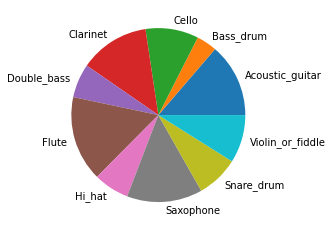

In [ ]:
plt.pie(class_dist,labels=class_dist.index)
plt.show()

## **Plotting**

In [ ]:
def calc_fft(y,rate):
  n=len(y)
  freq = np.fft.rfftfreq(n,d=1/rate)
  Y = abs(np.fft.rfft(y)/n)
  return (Y,freq)

def plot_signals(y):
  fig,axes=plt.subplots(nrows=2,ncols=5,figsize=(20,7))
  fig.suptitle('Time Series',size=18)
  keys=list(y.keys())
  i=0
  for r in range(2):
    for c in range(5):
      axes[r,c].set_title(keys[i])
      axes[r,c].plot(y[keys[i]])
      i+=1
  plt.show()

def plot_mfcc(mfccs):
  fig, axes=plt.subplots(nrows=2,ncols=5,figsize=(20,4))
  fig.suptitle('MFCC',size=18)
  i=0
  for r in range(2):
    for c in range(5):
      axes[r,c].set_title(list(mfccs.keys())[i])
      axes[r,c].imshow(list(mfccs.values())[i],cmap='hot')
      i+=1
  plt.show()

def plot_fbank(mfccs):
  fig, axes=plt.subplots(nrows=2,ncols=5,figsize=(20,6))
  fig.suptitle('Filter Bank Coefficients',size=18)
  i=0
  for r in range(2):
    for c in range(5):
      axes[r,c].set_title(list(mfccs.keys())[i])
      axes[r,c].imshow(list(mfccs.values())[i],cmap='hot')
      i+=1
  plt.show()

def plot_fft(fft):
  fig, axes=plt.subplots(nrows=2,ncols=5,figsize=(20,7))
  fig.suptitle('Fast Fourier Transform',size=18)
  i=0
  for r in range(2):
    for c in range(5):
      data=list(fft.values())[i]
      Y,freq=data[0],data[1]
      axes[r,c].set_title(list(fft.keys())[i])
      axes[r,c].plot(freq,Y)
      i+=1
  plt.show()

def envelope(y,rate,threshold):
  mask=[]
  y=pd.Series(y).apply(np.abs)
  y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
  for m in y_mean:
    if m > threshold:
      mask.append(True)
    else:
      mask.append(False)
  return mask

In [ ]:
signals={}
fft={}
fbank={}
mfccs={}

for i in instruments:
  wav_file=df[df['label']==i].iloc[0,0]
  signal,rate=librosa.load('/content/drive/My Drive/wavfiles/'+i+'/'+wav_file,sr=44100)
  mask=envelope(signal,rate,0.0005)
  signal=signal[mask]
  signals[i]=signal

  fft[i]=calc_fft(signal,rate)

  bank=logfbank(signal[:rate],rate,nfilt=26,nfft=1103).T
  fbank[i]=bank
  
  mel=mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=1103).T
  mfccs[i]=mel

In [ ]:
print(len(signals['Cello']))
print(fft['Cello'][0].shape,fft['Cello'][1].shape)
print(fbank['Cello'].shape)
print(mfccs['Cello'].shape)

214326
(107164,) (107164,)
(26, 99)
(13, 99)


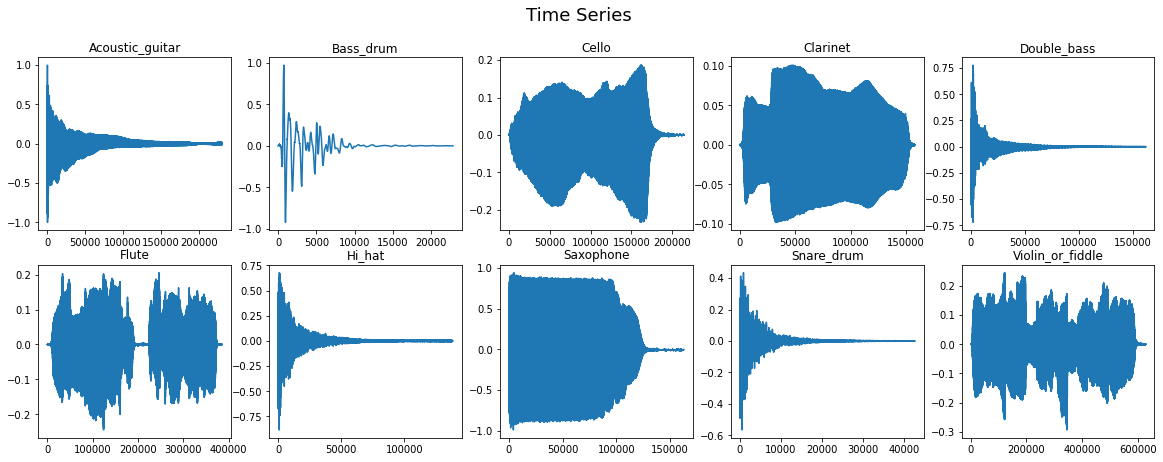

In [ ]:
plot_signals(signals)

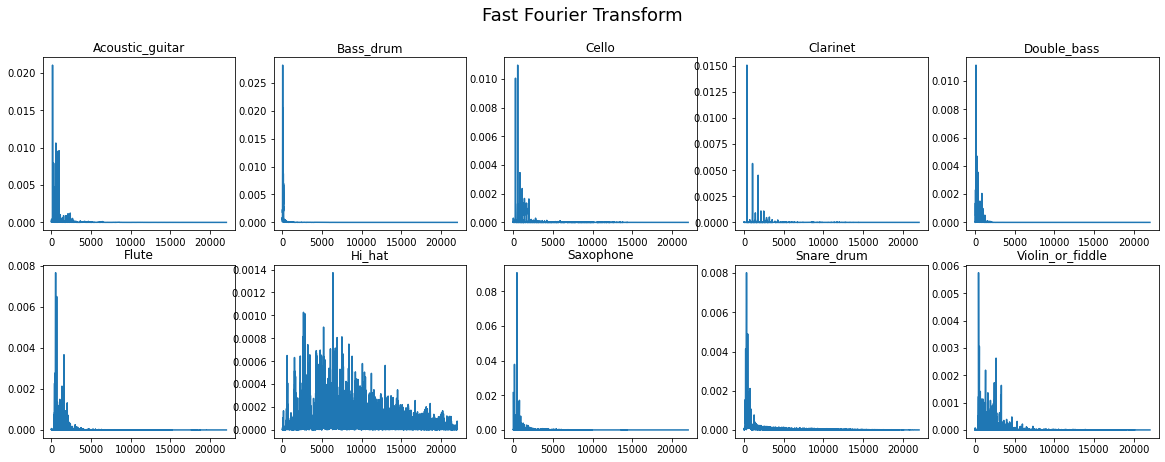

In [ ]:
plot_fft(fft)

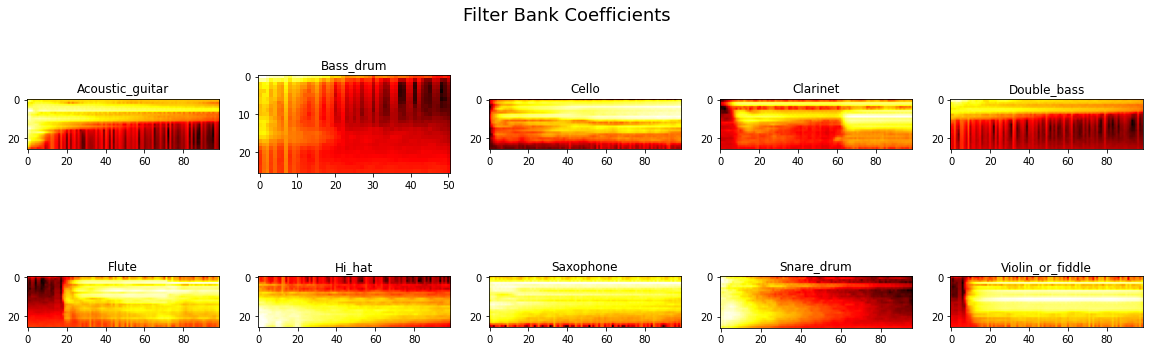

In [ ]:
plot_fbank(fbank)

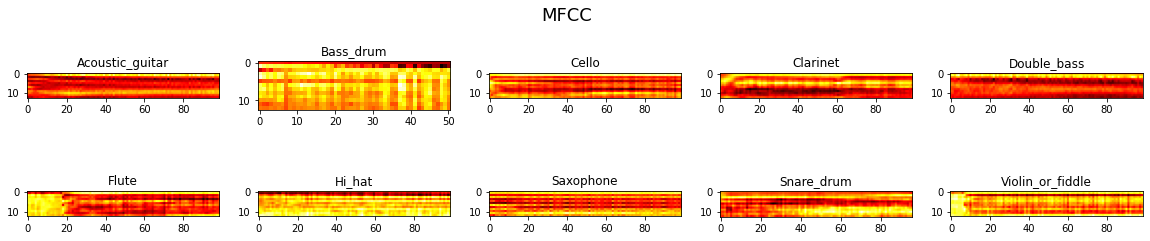

In [ ]:
plot_mfcc(mfccs)

In [ ]:
if len(os.listdir('/content/drive/My Drive/Clean_wavfiles'))==0:
  for f in tqdm(df.fname):
    i=df[df['fname']==f]['label'].values[0]
    signal,rate=librosa.load('/content/drive/My Drive/wavfiles/'+i+'/'+f,sr=16000)
    mask=envelope(signal,rate,0.0005)
    signal=signal[mask]
    wavfile.write(filename='/content/drive/My Drive/Clean_wavfiles/'+f,rate=rate,data=signal)

label
Acoustic_guitar     5.523710
Bass_drum           1.028431
Cello               4.857862
Clarinet            5.872040
Double_bass         2.877908
Flute               7.040535
Hi_hat              2.847860
Saxophone           6.864981
Snare_drum          2.817537
Violin_or_fiddle    4.286144
Name: length, dtype: float64


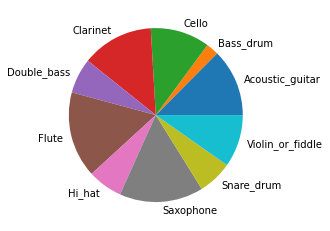

In [ ]:
df.set_index('fname',inplace=True)

for f in df.index:
  rate,signal=wavfile.read('/content/drive/My Drive/Clean_wavfiles/'+f)
  df.at[f,'length']=signal.shape[0]/rate

class_dist=df.groupby(['label'])['length'].mean()
print(class_dist)
#df.reset_index(inplace=True)

plt.pie(class_dist,labels=class_dist.index)
plt.show()

In [ ]:
n_samples=2*int(df['length'].sum()/0.1)
print(n_samples)

prob_dist=class_dist/class_dist.sum()
print(prob_dist)
choices = np.random.choice(class_dist.index,p=prob_dist)
print(choices)

26410
label
Acoustic_guitar     0.125490
Bass_drum           0.023364
Cello               0.110363
Clarinet            0.133404
Double_bass         0.065382
Flute               0.159950
Hi_hat              0.064699
Saxophone           0.155962
Snare_drum          0.064010
Violin_or_fiddle    0.097375
Name: length, dtype: float64
Clarinet


## **Generate audio samples**

In [ ]:
class Config:
  def __init__(self,mode='conv',nfilt=26,nfeat=13,nfft=512,rate=16000):
    self.mode=mode
    self.nfilt=nfilt
    self.nfeat=nfeat
    self.nfft=nfft
    self.rate=rate
    self.step=int(rate/10)

config=Config(mode='conv')

def build_rand_feat():
  X=[]
  y=[]
  mn,mx = float('inf'),-float('inf')
  for i in tqdm(range(n_samples)):
    rand_class=np.random.choice(class_dist.index,p=prob_dist)
    wav_file=np.random.choice(df[df['label']==rand_class].index)
    rate,signal = wavfile.read('/content/drive/My Drive/Clean_wavfiles/'+wav_file)
    label=df.at[wav_file,'label']
    rand_index=np.random.randint(0,signal.shape[0]-config.step)
    sample = signal[rand_index:(rand_index + config.step)]
    X_sample=mfcc(sample,rate,nfilt=config.nfilt,numcep=config.nfeat,nfft=config.nfft)
    mn=min(np.amin(X_sample),mn)
    mx=max(np.amax(X_sample),mx)
    X.append(X_sample)
    y.append(instruments.index(label))
  config.min_=mn
  config.max_=mx
  X,y=np.array(X),np.array(y)
  X=(X-mn)/(mx-mn)
  if config.mode == 'conv':
    X=X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
  elif config.mode == 'time':
    X=X.reshape(X.shape[0],X.shape[1],X.shape[2])
  y=to_categorical(y,num_classes=10)
  return X,y

## **Create Deep learning model**

In [ ]:
def get_conv_model():
  model = Sequential()
  model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
  model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same'))
  model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same'))
  model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128,activation='relu'))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(10,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  model.summary()
  return model

def get_reccurent_model():
  model=Sequential()
  model.add(LSTM(128,return_sequences=True,input_shape=input_shape))
  model.add(LSTM(128,return_sequences=True))
  model.add(Dropout(0.5))
  model.add(TimeDistributed(Dense(64,activation='relu')))
  model.add(TimeDistributed(Dense(32,activation='relu')))
  model.add(TimeDistributed(Dense(16,activation='relu')))
  model.add(TimeDistributed(Dense(8,activation='relu')))
  model.add(Flatten())
  model.add(Dense(10,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  model.summary()
  return model

if config.mode=='conv':
  X,y = build_rand_feat()
  y_flat = np.argmax(y,axis=1)
  input_shape = (X.shape[1],X.shape[2],1)
  model = get_conv_model()

elif config.mode=='time':
  X,y = build_rand_feat()
  y_flat = np.argmax(y,axis=1)
  input_shape = (X.shape[1],X.shape[2])
  model = get_reccurent_model()

class_weight  = compute_class_weight('balanced',np.unique(y_flat),y_flat)

100%|██████████| 26410/26410 [01:48<00:00, 243.69it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)             

In [ ]:
model.fit(X,y,validation_split=0.3,epochs=10,batch_size=32,shuffle=True,class_weight=class_weight)

Train on 18487 samples, validate on 7923 samples
Epoch 1/10
18487/18487 [==============================] - 14s 752us/step - loss: 1.1466 - accuracy: 0.5897 - val_loss: 0.6739 - val_accuracy: 0.7716
Epoch 2/10
18487/18487 [==============================] - 8s 407us/step - loss: 0.5909 - accuracy: 0.7967 - val_loss: 0.4274 - val_accuracy: 0.8581
Epoch 3/10
18487/18487 [==============================] - 8s 406us/step - loss: 0.4149 - accuracy: 0.8567 - val_loss: 0.3366 - val_accuracy: 0.8831
Epoch 4/10
18487/18487 [==============================] - 8s 416us/step - loss: 0.3238 - accuracy: 0.8900 - val_loss: 0.2637 - val_accuracy: 0.9125
Epoch 5/10
18487/18487 [==============================] - 8s 419us/step - loss: 0.2625 - accuracy: 0.9073 - val_loss: 0.2237 - val_accuracy: 0.9282
Epoch 6/10
18487/18487 [==============================] - 8s 407us/step - loss: 0.2366 - accuracy: 0.9174 - val_loss: 0.2459 - val_accuracy: 0.9167
Epoch 7/10
18487/18487 [==============================] - 8s 4

## **Save the model**

In [ ]:
#!pip install h5py
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")


## **Load the model**

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")
 
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Musical Instrument Prediction**




In [ ]:
X_test=[]
y_test=[]
wav_file = 'e92bf0fa.wav'
signal,rate=librosa.load('/content/drive/My Drive/wavfiles/Acoustic_guitar/'+wav_file,sr=16000)
label=df.at[wav_file,'label']
rand_index=np.random.randint(0,signal.shape[0]-config.step)
sample = signal[rand_index:(rand_index + config.step)]
X_sample=mfcc(sample,rate,nfilt=config.nfilt,numcep=config.nfeat,nfft=config.nfft)
X_test.append(X_sample)
y_test.append(instruments.index(label))
X_test,y_test=np.array(X_test),np.array(y_test)
X_test=(X_test-config.min_)/(config.max_-config.min_)
if config.mode == 'conv':
  X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
elif config.mode == 'time':
  X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

y_test=to_categorical(y_test,num_classes=10)

y_pred=loaded_model.predict_classes(X_test)
y_pred=instruments[y_pred[0]]

print('Actual instruments:',label)
print('Predicted instruments:', y_pred)

Actual instruments: Acoustic_guitar
Predicted instruments: Acoustic_guitar
